In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

In [2]:
# Data normalization

def norm_zScore(y):
    ''' Normalize a 1D array by z-score '''
    mean, std = np.mean(y), np.std(y)
    return np.array([(j-mean)/std for j in y]), mean, std

def denorm_zScore(yNorm, mean, std):
    return np.array([j*std + mean for j in yNorm])

def norm_matrix_cols(matrix, normalizer):
    return np.array([normalizer(col)[0] for col in matrix.T]).T


In [3]:
# Morgan Fingerprints

def get_fp_counts(mols, radius=3, return_inventory=False):
    fp_raw = [AllChem.GetMorganFingerprint(m, radius=radius) for m in mols]
    FP_INVENTORY= sorted(set(key for fp in fp_raw for key in fp.GetNonzeroElements()))

    fp_counts = np.zeros((len(mols), len(FP_INVENTORY))) # Integer matrix
    for m, fp in enumerate(fp_raw):
        for k,v in fp.GetNonzeroElements().items():
            fp_counts[m][FP_INVENTORY.index(k)] = v
            
    if return_inventory:
        return fp_counts, FP_INVENTORY
    return fp_counts
            

def get_fp_hashed(mols, nBits=2048, radius=3, counts=True):
    ''' Given a list (mols) of rdkit-encoded molecules,
        return an indicator matrix of nBit Morgan fingerprints,
        i.e. each row is the morgan representation of a molecule,
        use counts=True for count-based or False for binary vectors
    '''
    if counts: morgan = AllChem.GetHashedMorganFingerprint
    else: morgan = AllChem.GetMorganFingerprintAsBitVect
    out = []
    for m, mol in enumerate(mols):
        fp = morgan(mol, nBits=nBits, radius=3)
        vector = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, vector)
        out.append(vector)
    return np.array(out, dtype=int)


In [4]:
# CROW Polymer Database
crow = pd.read_csv("CROW_PolymerDatabase.csv", skiprows=2, usecols = [2,6]).dropna()
crow_smiles = np.array(crow['SMILES'])
crow_mols = np.array([Chem.MolFromSmiles(sm) for sm in crow_smiles])


# Morgan Fingerprints
crow_fp_counts, crow_fp_inventory = get_fp_counts(crow_mols, 3, True)
crow_fp_bits = np.where(crow_fp_counts > 0, 1, 0)
crow_fp_counts_2048 = get_fp_hashed(crow_mols, 2048, 3)
crow_fp_bits_2048 = np.where(crow_fp_counts_2048 > 0, 1, 0)


# Glass Transition Temp (Labels)
crow_Tg_Kelvin = np.array(crow['Glass Trans'], dtype=int)
crow_Tg_Celsius = crow_Tg_Kelvin - 273 # Celsius
crow_Tg_zScore = norm_zScore(crow['Glass Trans'])[0]

print('Database Imported:\tCROW PolymerDatabase (Glass Transition Temperature)')
crow

Database Imported:	CROW PolymerDatabase (Glass Transition Temperature)


,SMILES,Glass Trans
2,[*]CC[*],193.0
3,[*]CC([*])C,264.0
4,[*]CC([*])CC,245.0
5,[*]CC([*])CCC,238.0
6,[*]CC([*])CCCC,223.0
...,...,...
281,[*]CC([*])SCCCC,253.0
282,[*]CC([*])Sc1ccccc1,386.0
285,[*]O[Si]([*])(C)C,149.0
286,[*]O[Si]([*])(CC)CC,137.0


In [5]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    pd.DataFrame(crow_fp_counts, columns=crow_fp_inventory).to_csv('crow_fp_counts.csv', index=False)

In [6]:
# chemprop's "Extended String Represenation"

if False: #__name__ == "__main__" and '__file__' not in globals():
    
    fileName = 'crow_TgZ_chemprop.csv'
    with open(fileName, 'w') as f:
        f.write('Extended_String_Representation,Tg_zScore\n')
        for sm, tg in zip(crow_smiles, crow_Tg_zScore):
            chemprop_str = sm.replace('[*]','[*:1]', 1).replace('[*]','[*:2]', 1) + '|1|<1-2:1:1'
            f.write(f'{chemprop_str},{tg}\n')
    print(f'downloaded: {fileName}')

Number of datapoints not included in any test set: 23


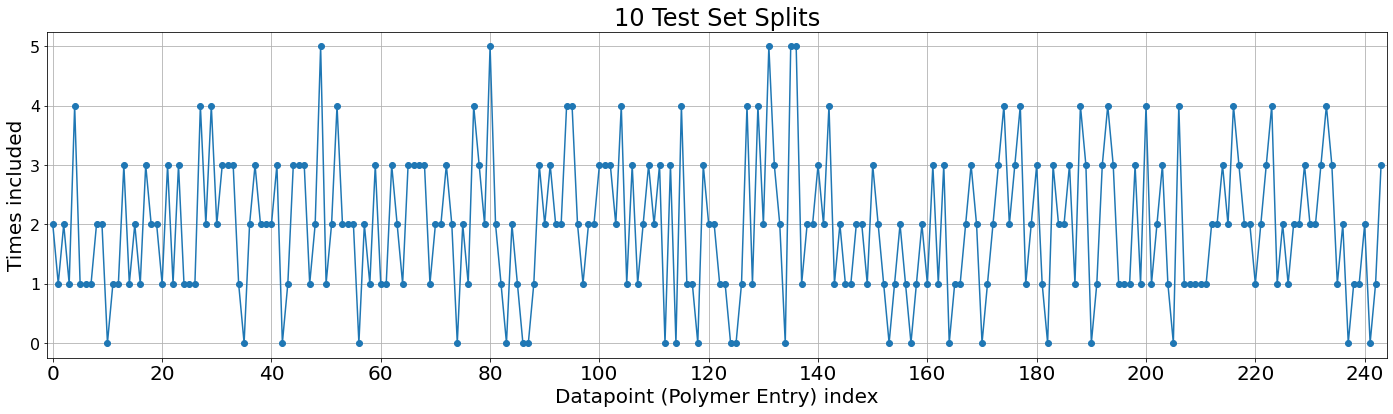

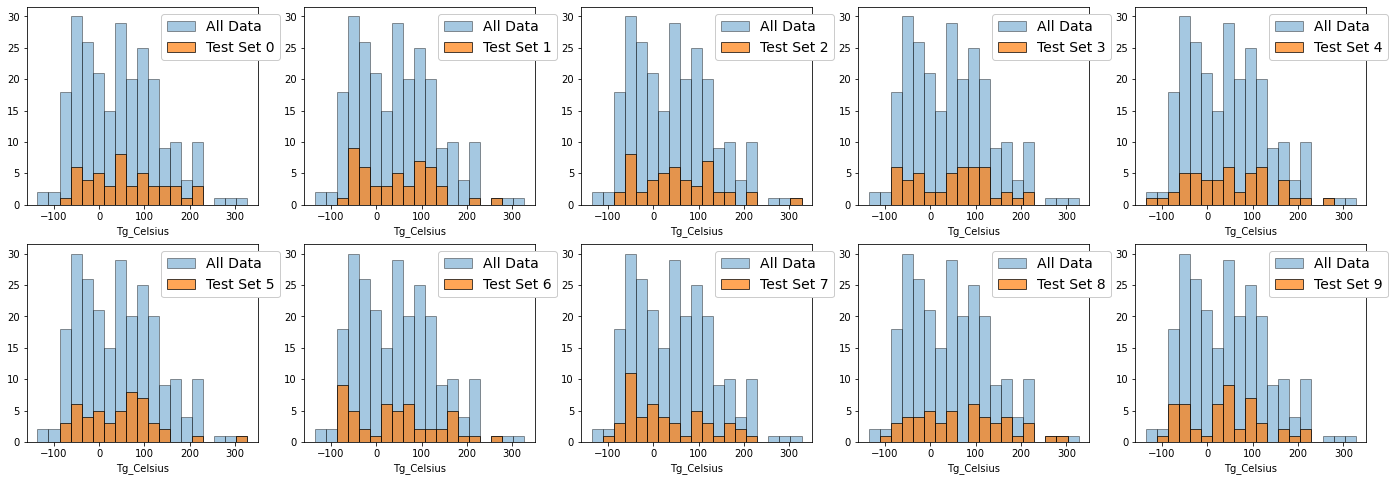

In [7]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    NEW_SPLIT = False
    
    if NEW_SPLIT:
        TEST_SIZE = 0.2
        max_inclusions, unincluded = 100, 100
        while max_inclusions > 5 or unincluded > len(crow)/10:
            ''' Let no data entry be part of more than 5 of the 10 test set splits
                and 90% of data entries be part of at least one test set
            '''
            TEN_TEST_INDICES = [sorted(np.random.choice(list(range(len(crow))), size=int(TEST_SIZE*len(crow)),
                                   replace=False)) for i in range(10)]
            inclusions = [0] * len(crow)
            for test_idx in TEN_TEST_INDICES:
                for i in test_idx:
                    inclusions[i] += 1
            max_inclusions = max(inclusions)
            unincluded = inclusions.count(0)
            
        with open('TEN_TEST_INDICES.txt', 'w') as f:
            f.write(f'{TEN_TEST_INDICES}')
            
    else:
        with open('TEN_TEST_INDICES_v6.txt') as f:
            TEN_TEST_INDICES = eval(f.read())
        inclusions = [0] * len(crow)
        for test_idx in TEN_TEST_INDICES:
            for i in test_idx:
                inclusions[i] += 1
        unincluded = inclusions.count(0)
        
    print('Number of datapoints not included in any test set:', unincluded)
    plt.figure(figsize=(24,6))
    plt.plot(inclusions, 'o-')
    plt.title('10 Test Set Splits', size=24)
    plt.xlabel('Datapoint (Polymer Entry) index', size=20)
    plt.ylabel('Times included', size=20)
    plt.xlim(-1, len(crow))
    plt.xticks(np.arange(0,250,20), size=20)
    plt.yticks(size=16)
    plt.grid()
    
    bins = np.linspace(min(crow_Tg_Celsius), max(crow_Tg_Celsius), 20)
    plt.figure(figsize=(24,8))
    for i,ti in enumerate(TEN_TEST_INDICES):
        plt.subplot(2,5,i+1)
        plt.xlabel('Tg_Celsius')
        plt.hist(crow_Tg_Celsius, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
        test_idx = np.array(ti)
        plt.hist(crow_Tg_Celsius[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
        #plt.title(f'Test Set #{i}', size=16)
        plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0.55,1), loc='upper left')
    if NEW_SPLIT: plt.savefig(f'TEN_TEST_INDICES.png', facecolor='w', bbox_inches='tight')


[17, 29, 31, 44, 49, 51, 68, 75, 77, 78, 81, 91]


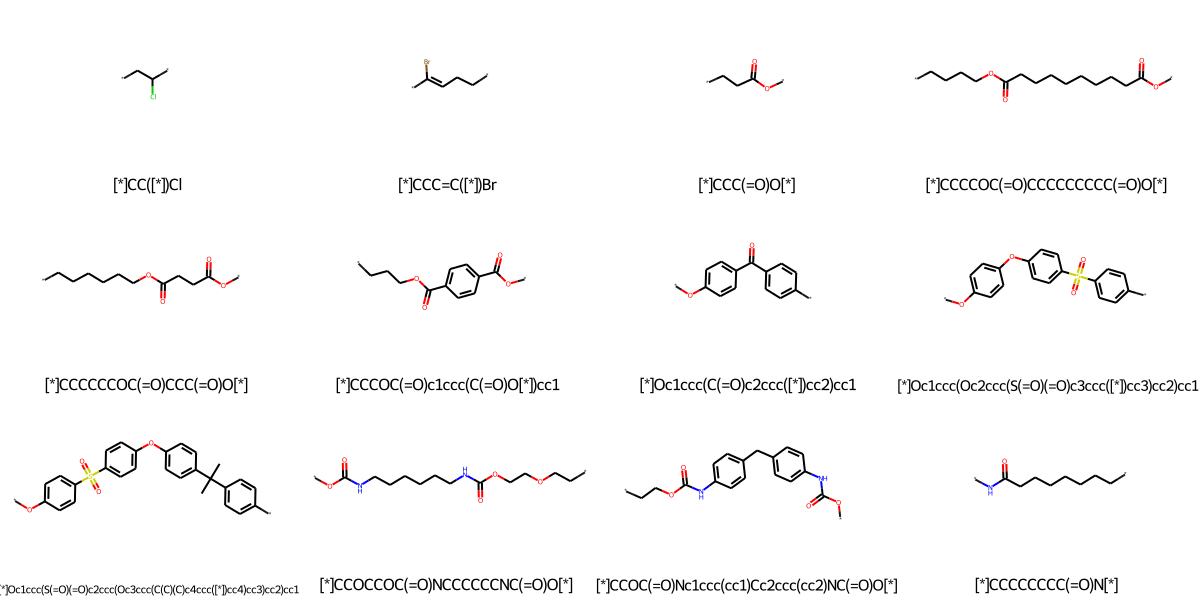

done


In [8]:
if __name__ == "__main__" and '__file__' not in globals():
    with open('TEN_TEST_INDICES_v6.txt') as f:
        some_mol_indices = eval(f.read())[0][:12]
    print(some_mol_indices)
    some_mols = crow_mols[some_mol_indices]
    some_smiles = crow_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, subImgSize=(300,200), legends=list(some_smiles))
    display(some_drawings)
    print('done')

In [9]:
if __name__ == "__main__" and '__file__' not in globals():
    print('crow_Tg St.Dev:\t', np.std(crow_Tg_Celsius), '[deg C]')

crow_Tg St.Dev:	 86.12897225828372 [deg C]


In [10]:
# Freesolv Database
freesolv = pd.read_csv('freesolv.txt', sep='; ', skiprows=2, engine='python')
freesolv_smiles = np.array(freesolv['SMILES'])
freesolv_mols = np.array([Chem.MolFromSmiles(sm) for sm in freesolv_smiles])
freesolv_fp_counts, freesolv_fp_inventory = get_fp_counts(freesolv_mols, 3, True)
freesolv_fp_bits = np.where(freesolv_fp_counts > 0, 1, 0)
freesolv_fp_counts_2048 = get_fp_hashed(freesolv_mols, 2048, 3)
freesolv_fp_bits_2048 = np.where(freesolv_fp_counts_2048 > 0, 1, 0)

freesolv_DGhy_exp = np.array(freesolv['experimental value (kcal/mol)'])
freesolv_DGhy_exp_err = np.array(freesolv['experimental uncertainty (kcal/mol)'])
freesolv_DGhy_calc = np.array(freesolv['Mobley group calculated value (GAFF) (kcal/mol)'])
freesolv_DGhy_calc_err = np.array(freesolv['calculated uncertainty (kcal/mol)'])
freesolv_DGhy_exp_zScore = norm_zScore(freesolv_DGhy_exp)[0]

print('Database Imported:\tFreesolv (Hydration Free Energy)')
freesolv

Database Imported:	Freesolv (Hydration Free Energy)


,# compound id (and file prefix),SMILES,iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem),experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
0,mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
1,mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
2,mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1007/s10822-011-9528-8,Experimental uncertainty not presently availab...
3,mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
4,mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provide...",10.1021/ct800409d,Experimental uncertainty not presently availab...
...,...,...,...,...,...,...,...,...,...,...
638,mobley_9913368,C(=C/Cl)\Cl,"(E)-1,2-dichloroethylene",-0.78,0.6,1.02,0.02,10.1021/ct050097l,10.1021/ct800409d,"Renamed mobley_9913368 from (E)-1,2-dichloroet..."
639,mobley_9942801,CCc1ccc(cc1)C,1-ethyl-4-methyl-benzene,-0.95,0.6,-0.57,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
640,mobley_994483,CCBr,bromoethane,-0.74,0.6,0.49,0.02,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
641,mobley_9974966,CC(C)SC(C)C,2-isopropylsulfanylpropane,-1.21,0.6,0.14,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...


Number of datapoints not included in any test set: 63


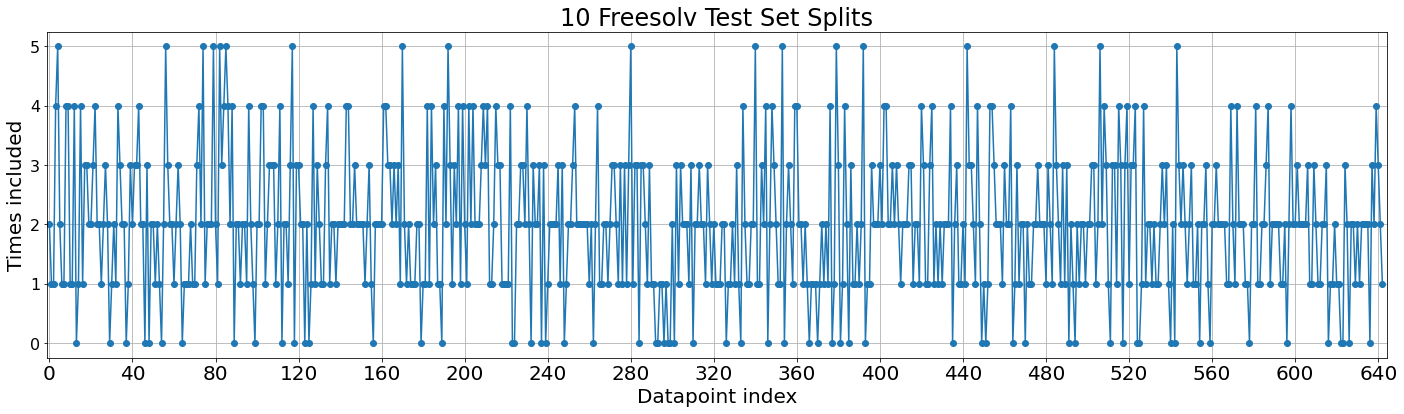

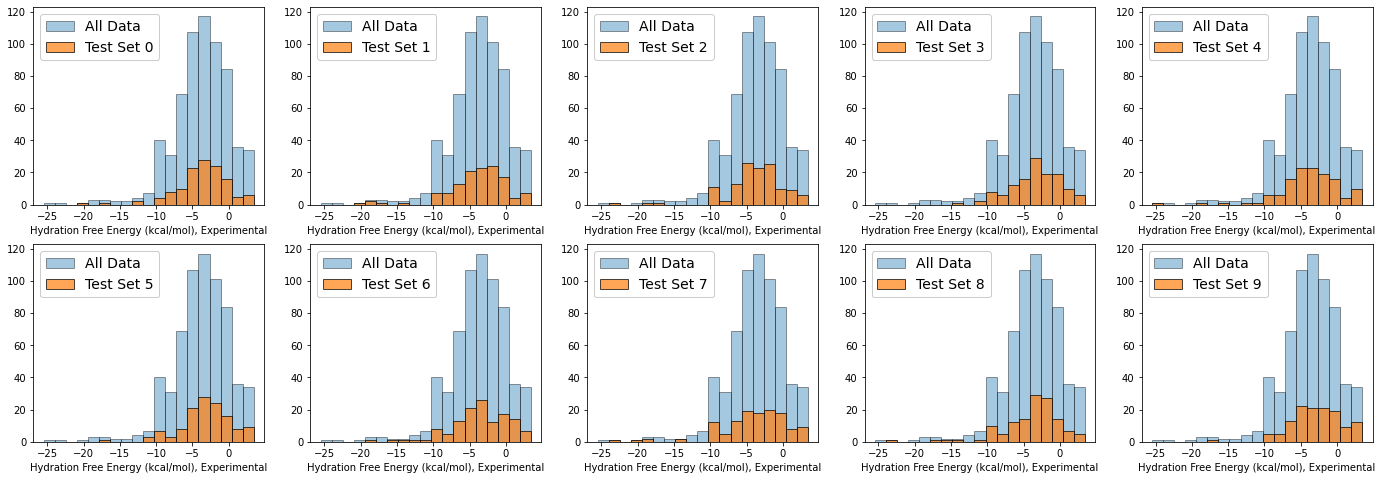

In [11]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    NEW_FREESOLV_SPLIT = False
    
    if NEW_FREESOLV_SPLIT:
        
        TEST_SIZE = 0.2
        
        max_inclusions, unincluded = 100, 100
        while max_inclusions > 5 or unincluded > len(freesolv)/10:
            ''' Let no data entry be part of more than 5 of the 10 test set splits
                and 90% of data entries be part of at least one test set
            '''
            TEN_FREESOLV_TEST_INDICES = [sorted(np.random.choice(list(range(len(freesolv))), size=int(TEST_SIZE*len(freesolv)),
                                   replace=False)) for i in range(10)]
            inclusions = [0] * len(freesolv)
            for test_idx in TEN_FREESOLV_TEST_INDICES:
                for i in test_idx:
                    inclusions[i] += 1
            max_inclusions = max(inclusions)
            unincluded = inclusions.count(0)
            # print(max_inclusions, unincluded)
            
        with open('TEN_FREESOLV_TEST_INDICES.txt', 'w') as f:
            f.write(f'{TEN_FREESOLV_TEST_INDICES}')
            
    else:
        with open('TEN_FREESOLV_TEST_INDICES_v1.txt') as f:
            TEN_FREESOLV_TEST_INDICES = eval(f.read())
        inclusions = [0] * len(freesolv)
        for test_idx in TEN_FREESOLV_TEST_INDICES:
            for i in test_idx:
                inclusions[i] += 1
        unincluded = inclusions.count(0)
        
    print('Number of datapoints not included in any test set:', unincluded)
    plt.figure(figsize=(24,6))
    plt.plot(inclusions, 'o-')
    plt.title('10 Freesolv Test Set Splits', size=24)
    plt.xlabel('Datapoint index', size=20)
    plt.ylabel('Times included', size=20)
    plt.xlim(-1, len(freesolv)+1)
    plt.xticks(np.arange(0,661,40), size=20)
    plt.yticks(size=16)
    plt.grid()
    
    bins = np.linspace(min(freesolv_DGhy_exp), max(freesolv_DGhy_exp), 20)
    plt.figure(figsize=(24,8))
    for i,ti in enumerate(TEN_FREESOLV_TEST_INDICES):
        plt.subplot(2,5,i+1)
        plt.xlabel('Hydration Free Energy (kcal/mol), Experimental')
        plt.hist(freesolv_DGhy_exp, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
        test_idx = np.array(ti)
        plt.hist(freesolv_DGhy_exp[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
        #plt.title(f'Test Set #{i}', size=16)
        plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')
    if NEW_FREESOLV_SPLIT: plt.savefig(f'TEN_FREESOLV_TEST_INDICES.png', facecolor='w', bbox_inches='tight')


[3, 4, 16, 17, 18, 23, 31, 32, 34, 36, 38, 42]


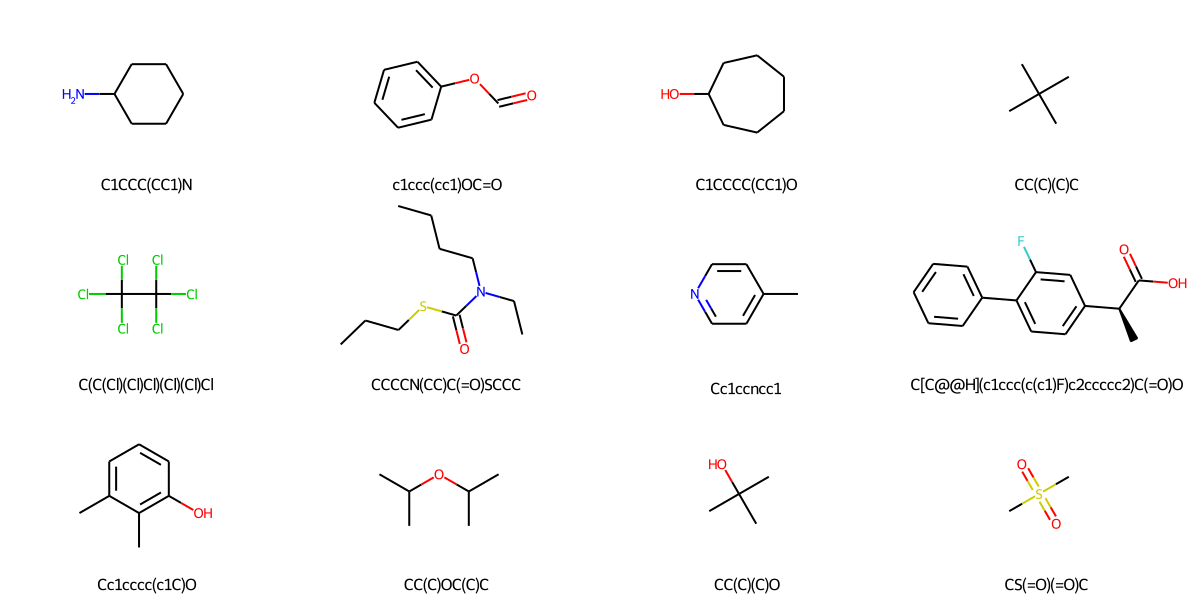

done


In [12]:
if __name__ == "__main__" and '__file__' not in globals():
    with open('TEN_FREESOLV_TEST_INDICES_v1.txt') as f:
        some_mol_indices = eval(f.read())[0][:12]
    print(some_mol_indices)
    some_mols = freesolv_mols[some_mol_indices]
    some_smiles = freesolv_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, subImgSize=(300,200), legends=list(some_smiles))
    display(some_drawings)
    print('done')

In [13]:
if __name__ == "__main__" and '__file__' not in globals():
    print('Unique fingerprints in Freesolv database:', len(freesolv_fp_inventory))
    print('freesolv_DGhy_exp St.Dev:\t', np.std(freesolv_DGhy_exp), '[kcal/mol]')

Unique fingerprints in Freesolv database: 3181
freesolv_DGhy_exp St.Dev:	 3.843131787620932 [kcal/mol]


In [14]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    
    fileName = 'freesolv_DGhy_exp.csv'
    with open(fileName, 'w') as f:
        f.write('SMILES,Experimental Hydration Free Energy [kcal/mol]\n')
        for sm, dg in zip(freesolv_smiles, freesolv_DGhy_exp):
            f.write(f'{sm},{dg}\n')
    print(f'downloaded: {fileName}')

In [25]:
# Bicerano_1996 with MD calculations by Azfal_2021
bicerano = pd.read_csv('Azfal_Bicerano.csv', skiprows=1)
bicerano_smiles = np.array(bicerano['SMILES'])
bicerano_mols = np.array([Chem.MolFromSmiles(sm) for sm in bicerano_smiles])
# bicerano_fp_counts, bicerano_fp_inventory = get_fp_counts(bicerano_mols, 3, True)
# bicerano_fp_bits = np.where(bicerano_fp_counts > 0, 1, 0)
# bicerano_fp_counts_2048 = get_fp_hashed(bicerano_mols, 2048, counts=True)
# bicerano_fp_bits_2048 = np.where(bicerano_fp_counts_2048 > 0, 1, 0)

bicerano_Tg_Kelvin = np.array(bicerano['Experiment Tg (K)'])
bicerano_Tg_Celsius = bicerano_Tg_Kelvin - 273
azfal_Tg_Kelvin = np.array(bicerano['Calculated Tg (K)'])
azfal_Tg_Celsius = azfal_Tg_Kelvin - 273
azfal_Tg_err = np.array(bicerano['Calculated Tg St.Dev. (K)'])

print('Database Imported:\tBicerano_1996 (Glass Transition Temperature) with MD simulations by Azfal_2021')
bicerano

Database Imported:	Bicerano_1996 (Glass Transition Temperature) with MD simulations by Azfal_2021


,SMILES,Experiment Tg (K),Calculated Tg (K),Calculated Tg St.Dev. (K)
0,[*]O[Si](CC)(CC)[*],130,138.0,3.8
1,[*][Si](C)(C)O[*],152,193.3,51.1
2,[*]C/C=C\C[*],171,211.7,3.1
3,[*][Si](C)(C)C[*],173,258.7,4.7
4,[*][Si](C)(C1=CC=CC=C1)O[*],187,286.9,5.8
...,...,...,...,...
310,[*]C3=C(N=C2C=C1N=C(C(=NC1=CC2=N3)C4=CC=C(C=C4...,668,951.1,48.6
311,[*]C3=C(N=C2C=C1N=C(C(=NC1=CC2=N3)C4=CC(=CC=C4...,668,693.4,37.1
312,[*]C1=CC=C(C=C1)N5C(=O)C4=CC2=C(C(N(C2=O)C3=CC...,672,817.2,39.0
313,[*]C1=CC=C(C=C1)C1(OC(=O)C2=CC=CC=C12)C1=CC=C(...,673,842.1,38.1


In [16]:
# for sm in bicerano_smiles:
#     print(sm)
#     mol = Chem.MolFromSmiles(sm)
#     fp = AllChem.GetMorganFingerprint(mol)

[*]O[Si](CC)(CC)[*]


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(Mol)
did not match C++ signature:
    GetMorganFingerprint(class RDKit::ROMol mol, int radius, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

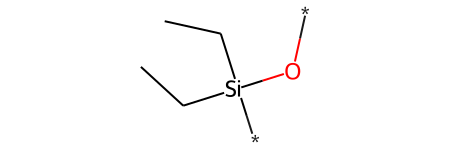

In [21]:
# mol = Chem.MolFromSmiles('[*]O[Si](CC)(CC)[*]')
# mol

In [18]:
# AllChem.GetMorganFingerprint(Chem.MolFromSmiles('[*]CC[*]'))

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(Mol)
did not match C++ signature:
    GetMorganFingerprint(class RDKit::ROMol mol, int radius, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [ ]:
# [print(i, sm) for i, sm in enumerate(bicerano_smiles)]
# None

In [22]:
# crow_smiles[0]

'[*]CC[*]'

In [23]:
# AllChem.GetMorganFingerprint(Chem.MolFromSmiles(crow_smiles[0]))

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(Mol)
did not match C++ signature:
    GetMorganFingerprint(class RDKit::ROMol mol, int radius, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [28]:
crow_mols

array([<rdkit.Chem.rdchem.Mol object at 0x0000027DF63602B0>,
       <rdkit.Chem.rdchem.Mol object at 0x0000027DF63B0120>], dtype=object)

In [27]:
get_fp_counts(crow_mols, 3)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
bicerano_mols

array([<rdkit.Chem.rdchem.Mol object at 0x0000027DF74C0210>,
       <rdkit.Chem.rdchem.Mol object at 0x0000027DF74EA7B0>, None,
       <rdkit.Chem.rdchem.Mol object at 0x0000027DF74ED710>], dtype=object)

In [30]:
get_fp_counts(bicerano_mols, 3)

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(class RDKit::ROMol mol, int radius, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [32]:
bicerano_smiles[list(bicerano_mols).index(None)]

'CC(C)(c1ccc(O[[*]])cc1)c7ccc(Oc6ccc5c(=O)n(c4cccc(n3c(=O)c2ccc([[*]])cc2c3=O)c4)c(=O)c5c6)cc7'